In [1]:
import gensim.downloader as api
import time
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt
from web.datasets.similarity import *
from scipy.stats import kendalltau, spearmanr
import seaborn as sns

import sys
sys.path += ['utils/']  

from word_embedding import * 

import warnings
warnings.filterwarnings("ignore")

In [12]:
def LoadData(name):

    if name == 'text9':

        df = pd.read_csv('Bkp_vars/norm_enwik9')
        X = df.values
        del df
        text = [x[0].split(' ') for x in X]
        del X

    else: 
        dataset = api.load('text8')
        text = [a for a in dataset]
        if name == 'million':
            text = text[:99] # one million words
            
    return text

def ComputePerf(model):
    
    datasets = [fetch_MEN(which = 'test'), fetch_WS353(which = 'similarity'), fetch_SimLex999(), fetch_TR9856(),
                fetch_RG65(), fetch_MTurk()]
    
    words_gensim = [w for w in model.wv.key_to_index.keys()]
    
    v = []

    for ds in datasets:

        w1 = ds['X'][:,0]
        w2 = ds['X'][:,1]
        score = ds['y']

        sim = []
        sscore = []

        for x, y, s in zip(w1, w2, score):
            if x in words_gensim and y in words_gensim:
                sim.append(model.wv.similarity(x, y))
                sscore.append(s)

        r, _ = spearmanr(sim, sscore)
        v.append(r)
        
    
    return v


def RunSimulation(name, min_count):

    dim = 32
    n_epochs = 50
    η = .5
    γ = 0.75

    t0 = time()
    res, word2idx = WordEmbedding(text, dim = dim, γ = γ, n_epochs = n_epochs, verbose = True, 
                                min_count = min_count, η = η)

    t = time() - t0


    t0 = time()
    print('\nRunning W2Vec')
    model = Word2Vec(sentences = text, vector_size = dim, min_count = min_count, window = 3,
                     workers = 8, sample = 1e-5)

    tns = time() - t0


    datasets = [fetch_MEN(which = 'test'), fetch_WS353(which = 'similarity'), fetch_SimLex999(), fetch_TR9856(),
                fetch_RG65(), fetch_MTurk()]

    all_words = list(word2idx.keys())
    words_gensim = [w for w in model.wv.key_to_index.keys()]

    X = res.X
    Y = np.array([model.wv.get_vector(w) for w in model.wv.key_to_index.keys()])
    Y = normalize(Y, norm = 'l2', axis = 1)


    v1 = []
    v2 = []

    for ds in datasets:

        w1 = ds['X'][:,0]
        w2 = ds['X'][:,1]
        score = ds['y']

        sim = []
        nsim = []
        sscore = []

        for x, y, s in zip(w1, w2, score):
            if x in all_words and y in all_words:

                sim.append(X[all_words.index(x)]@X[all_words.index(y)])
                nsim.append(Y[words_gensim.index(x)]@Y[words_gensim.index(y)])
                sscore.append(s)

        r, _ = spearmanr(sim, sscore)
        v1.append(r)
        
        r, _ = spearmanr(nsim, sscore)
        v2.append(r)
        
    columns = ['MEN', 'WS353', 'SimLex999', 'TR9856', 'RG65', 'MTurk', 't']
    df = pd.DataFrame(columns = columns)
    df = pd.concat([df, pd.Series(dict(zip(columns, np.concatenate([v1, [t]])))).to_frame().T], ignore_index = True)
    df = pd.concat([df, pd.Series(dict(zip(columns, np.concatenate([v2, [tns]])))).to_frame().T], ignore_index = True)


    # save the result
    try:
        nn = (np.max([int(x.split('_')[1]) for x in os.listdir('saved_files/text/' + name)]))
        df.to_csv('saved_files/text/' + name + '/v_' + str(nn+1) + '_.csv', index = False)

    except:
        df.to_csv('saved_files/text/' + name + '/v_' + str(1) + '_.csv', index = False)
        
    return

In [22]:
# load the data
name = 'text9' # million, text8, text9

text = LoadData(name)

In [23]:
n_iterations = 3
min_count = 20

for nn in range(n_iterations):
    print('\n' + str(nn+1) + '/' + str(n_iterations) + '\n')
    RunSimulation(name, min_count)


1/3

Text pre-processing
Get the probability matrix


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   23.2s remaining:   38.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   23.9s remaining:   14.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   25.3s finished


Time elapsed before optimization: 314.2957351207733
Computing the embedding
Running the optimization for k = 1
[========================>] 100%
Running W2Vec

2/3

Text pre-processing
Get the probability matrix


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   40.8s remaining:  1.1min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   41.2s remaining:   24.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   41.7s finished


Time elapsed before optimization: 323.4864888191223
Computing the embedding
Running the optimization for k = 1
[========================>] 100%
Running W2Vec

3/3

Text pre-processing
Get the probability matrix


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   36.4s remaining:  1.0min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   36.8s remaining:   22.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   37.7s finished


Time elapsed before optimization: 294.85864210128784
Computing the embedding
Running the optimization for k = 1
[========================>] 100%
Running W2Vec


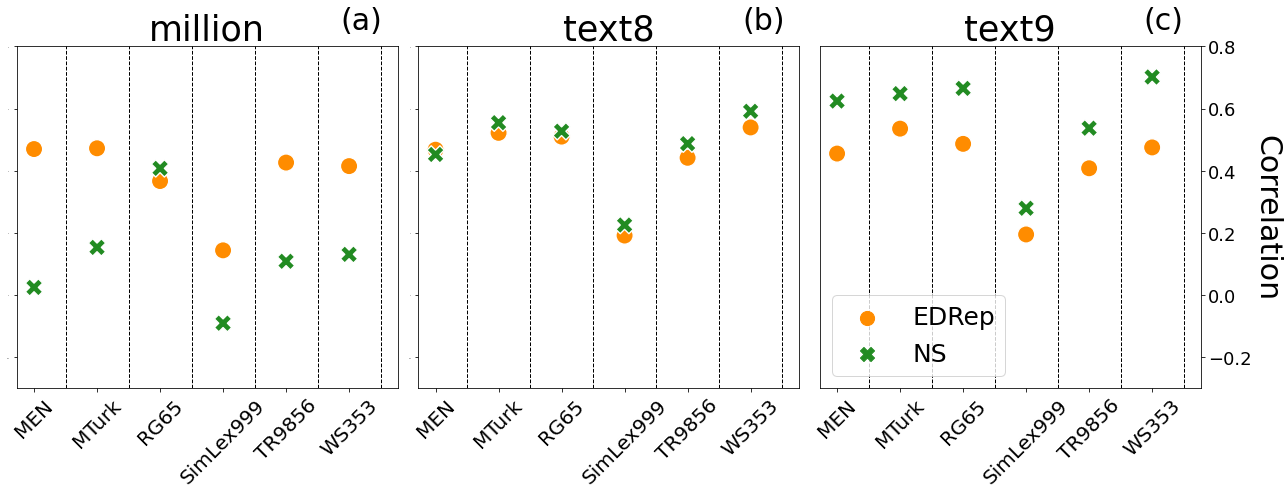

In [26]:
fig, ax = plt.subplots(1,3, figsize = (18, 7))

names = ['million', 'text8', 'text9']
columns = ['MEN', 'WS353', 'SimLex999', 'TR9856', 'RG65', 'MTurk', 't']

for i, name in enumerate(names):

    files = os.listdir('saved_files/text/' + name)
    df_list = []

    for file in files:
        df_list.append(pd.read_csv('saved_files/text/' + name + '/' + file))

    df = pd.concat(df_list).reset_index()

    df0 = pd.melt(df[df['index'] == 0], value_vars = ['MEN', 'WS353', 'SimLex999', 'TR9856', 'RG65', 'MTurk'])
    df1 = pd.melt(df[df['index'] == 1], value_vars = ['MEN', 'WS353', 'SimLex999', 'TR9856', 'RG65', 'MTurk'])

    df0 = df0.groupby('variable').mean().reset_index()
    df1 = df1.groupby('variable').mean().reset_index()

    df0['idx'] = 'EDRep'
    df1['idx'] = 'NS'

    df = pd.concat([df0, df1])


    sns.scatterplot(data = df, x = 'variable', y = 'value', hue = 'idx', style = 'idx', ax = ax[i], 
                   palette = ['darkorange', 'forestgreen'], s = 300)
    ax[i].get_legend().remove() 
    ax[i].set(xlabel=None)
    ax[i].set(ylabel=None)

    if i == 2:
        lgnd = ax[i].legend(fontsize = 25, loc = 3)   
        #change the marker size manually for both lines
        lgnd.legendHandles[0]._sizes = [200]
        lgnd.legendHandles[1]._sizes = [200]

    ax[i].set_ylim(-0.3, 0.80)
    ax[i].tick_params(axis='x', rotation = 45)
    ax[i].tick_params(axis = 'x', which = 'major', labelsize = 20)
    ax[i].tick_params(axis = 'y', which = 'major', labelsize = 0)

    ax[i].set_title(name, fontsize = 35)

    for j in range(len(columns)-1):
        ax[i].axvline(j+0.5, color = 'k', linestyle = '--', linewidth = 1)

ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
ax[2].set_ylabel('Correlation', fontsize = 30, rotation = -90, labelpad = 30)
ax[2].tick_params(axis = 'y', which = 'major', labelsize = 18)

ax[0].text(0.85, 1.05, '(a)', fontsize = 30, transform = ax[0].transAxes)
ax[1].text(0.85, 1.05, '(b)', fontsize = 30, transform = ax[1].transAxes)
ax[2].text(0.85, 1.05, '(c)', fontsize = 30, transform = ax[2].transAxes)
    
plt.tight_layout()
plt.savefig('../../paper/v2/arXiv/Figures/text.pdf', bbox_inches = 'tight')
plt.show();